   # LOGISTIC REGRESSION :


The model presented below tries to fit the best logistic model for the bank dataset. The analysis can be outlined in the following steps :
 1. Data exploration to figure out missing values ,numerical and categorical features
 2. Modules to find out categorical features and numerical features
 3. Feature scaling of numerical variables due to high discrepancies in ranges
 3. Create dummy variables for categorical variables using one hot encoding and label encoding
 4. Finding out best features using Recursive Forward Elimination
 5. Getting model 'Precision' [Number of positive cases correctly predicted] for various number of features
 6. Plot of number of features against precision, stopping when there's no gain in precision

  ### Accuracy : 89%
  ### Precision : 64%




In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

In [86]:
#Read data and get categoricals/integer distribution
data = pd.read_csv('bank-full.csv', sep = ';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [87]:
#Describe data and look at minimum and maximum values to feature scale high range numerical categs
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [88]:
#Feature scale all numerical features and have a look at statistics again
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_features = ['age', 'balance','day','duration','campaign','pdays','previous']
data[scale_features] = scaler.fit_transform(data[scale_features])

data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.297873,0.085171,0.493547,0.052494,0.028449,0.047245,0.002110
std,0.137906,0.027643,0.277416,0.052364,0.049968,0.114827,0.008376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.073457,0.233333,0.020943,0.000000,0.000000,0.000000
50%,0.272727,0.076871,0.500000,0.036600,0.016129,0.000000,0.000000
75%,0.389610,0.085768,0.666667,0.064864,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
#Converting data into Independent(X) and Dependent(Y) values : 
X = data.iloc[:,:16].values
Y = data.iloc[:,16:].values

In [90]:
#Functions to assist operations :

#----------------------------------------------------------------------------------------------------------------------    

def label_and_onehot_encode(data_matrix , indices, one_hot_encode_flag):
    ''' Description =>  
        Accepts a data matrix to label encode , and one hot encode specific columns of the matrix
    Params =>  
        data_matrix : the input matrix , 
        indices     : indexes of categorical columns in matrix 
        one_hot_encode_flag : Flag to specify if one hot coding is required in addition to label encoding
    Returns =>
        Returns a data matrix with encoded columns
        '''
    label_encoder = LabelEncoder()
    for i in indices:
        data_matrix[:,i] = label_encoder.fit_transform(data_matrix[:,i])
    if(one_hot_encode_flag):    
        one_hot_encoder = OneHotEncoder(categorical_features=indices)
        data_matrix = one_hot_encoder.fit_transform(data_matrix).toarray()
    return data_matrix
  
#----------------------------------------------------------------------------------------------------------------------    
    
def get_categorical_indices(data_frame):
    '''
       Returns the indices of categorical columns of a dataframe
    '''
    cols = data_frame.columns
    num_cols = data_frame._get_numeric_data().columns
    col_names_list =  list(set(cols)-set(num_cols))
    indices_list = sorted([data_frame.columns.get_loc(item) for item in col_names_list])
    return indices_list  

#----------------------------------------------------------------------------------------------------------------------    


def get_model_precision(X,Y):
    '''Runs Logistic Regression and returns precision ,accuracy , recall score and confusion matrix'''
    #Split the dataset into testing and training in ratio 4:1
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=1/5,random_state=0)

    #Fit Logistic regression to the training set
    from sklearn.linear_model import LogisticRegression
    classifier = LogisticRegression(random_state=0)
    classifier.fit(X_train, Y_train)

    #Predicting the test set results
    Y_pred = classifier.predict(X_test)

    #Generate Key Model performance Statistics
    from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
    cm= confusion_matrix(Y_test, Y_pred)
    model_acc = accuracy_score(Y_test, Y_pred)
    precision_sc = precision_score(Y_test,Y_pred)
    recall_sc = recall_score(Y_test, Y_pred)
    
    return [precision_sc,cm,model_acc,recall_sc]

#----------------------------------------------------------------------------------------------------------------------    

def get_n_best_predictors(X,Y,num_ftrs):
    
    #Recursive Feature Elimination
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression()
    # create the RFE model and select 3 attributes
    selector = RFE(model, num_ftrs)
    selector = selector.fit(X,Y)
        
    # summarize the selection of the attributes
    best_pred_indices = sorted(selector.get_support(indices=True))
    return best_pred_indices;


Num of features : 1 , Precision : 0.572
Num of features : 2 , Precision : 0.575
Num of features : 3 , Precision : 0.569
Num of features : 4 , Precision : 0.62
Num of features : 5 , Precision : 0.628
Num of features : 6 , Precision : 0.643
Num of features : 7 , Precision : 0.634
Num of features : 8 , Precision : 0.632


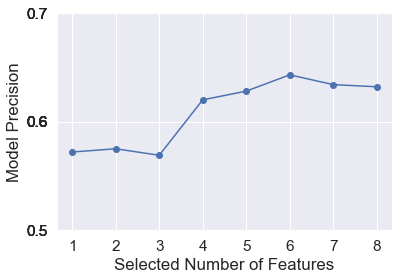

In [91]:
#Encode dummy variables for categoricals
X_categories_indices = get_categorical_indices(data.iloc[:,:16])
X = label_and_onehot_encode(X,X_categories_indices,True)
Y = label_and_onehot_encode(Y,[0],False)
Y = Y.astype('int')


#Select Optimum features for max precision in model
model_feature_sizes = list(range(1,9))  # No more precision gain after 5 features
nfeature_precision_map = {}
for i,model_feature_size in enumerate(model_feature_sizes):
    best_predictors = get_n_best_predictors(X,Y,model_feature_size)
    X_new = X.copy()[:,best_predictors]
    precision = get_model_precision(X_new,Y)[:2]
    nfeature_precision_map[model_feature_size]=precision
    print ('Num of features : {} , Precision : {}'.format(model_feature_size, round(precision[0],3)))


#Plot precisions against Number of Features
num_f = [x for x in nfeature_precision_map.keys()]
acc = [round(x[0],3) for x in nfeature_precision_map.values()]
plt.plot(num_f,acc, label='Logistic Regression Results', color ='b' ,marker = 'o')
plt.xlabel('Selected Number of Features')
plt.xticks(num_f)
plt.ylabel('Model Precision')
plt.yticks([round(x,1) for x in np.arange(0.5,0.7,0.01)])
plt.show()  